In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# sns.set_theme("paper", style="darkgrid")

## Loading Network

In [2]:
resources_path='/Users/kamrantehranchi/Library/CloudStorage/OneDrive-Stanford/Kamran_OSW/PyPSA_Models/pypsa-breakthroughenergy-usa/workflow/resources'
clustered_path='/Users/kamrantehranchi/Library/CloudStorage/OneDrive-Stanford/Kamran_OSW/PyPSA_Models/pypsa-breakthroughenergy-usa/workflow/resources/western/elec_s_50.nc'
network = pypsa.Network(clustered_path)

# network_solved = pypsa.Network('/Users/kamrantehranchi/Library/CloudStorage/OneDrive-Stanford/Kamran_OSW/PyPSA_Models/pypsa-breakthroughenergy-usa/workflow/notebooks/Solved_Network_WECC_50.nc')

INFO:pypsa.io:Imported network elec_s_50.nc has buses, carriers, generators, lines, links, loads


In [3]:
# network.plot(margin=0.3 ,bus_sizes=0.05, line_widths=0.3)
network.iplot(mapbox=True, mapbox_token='pk.eyJ1Ijoia3RlaHJhbmNoaSIsImEiOiJjbDJzNW5kdHMwaGJzM2pudDBsazZ5am80In0.hQfjJnhiiO1-YcJEEpN-1A',size= (1000,700));

In [27]:
network.lines 

,bus0,bus1,r,x,b,s_nom,s_max_pu,length,num_parallel,type,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
Line,,,,,,,,,,,,,,,,,,,,,
1,AVA0 0,BPAT0 1,4.921142,33.328201,0.000034,10000,1.0,286.591033,0.360000,,...,inf,0,0.000630,0.000093,0.0,1.806749,0.000630,0.000093,0.0,230.0
2,AVA0 0,BPAT0 2,0.847388,5.990092,0.000139,10000,11.0,228.530547,7.740000,,...,inf,0,0.000113,0.000016,0.0,7.332470,0.000113,0.000016,0.0,230.0
3,AVA0 0,BPAT0 4,1.332076,17.453704,0.000055,10000,4.0,246.090182,15.922854,,...,inf,0,0.000330,0.000025,0.0,2.929387,0.000330,0.000025,0.0,230.0
4,AVA0 0,DOPD0 0,0.979313,10.528460,0.000070,10000,6.0,230.247931,16.642854,,...,inf,0,0.000199,0.000019,0.0,3.680059,0.000199,0.000019,0.0,230.0
5,AVA0 0,IPCO0 0,6.940746,211.460261,0.000026,10000,1.0,614.940313,11.062854,,...,inf,0,0.003997,0.000131,0.0,1.366133,0.003997,0.000131,0.0,230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,PNM0 0,TEPC0 0,7.826101,96.471081,0.000057,10000,2.0,602.896890,4.975898,,...,inf,0,0.001824,0.000148,0.0,2.998033,0.001824,0.000148,0.0,230.0
116,PNM0 0,WACM0 0,3.387828,22.412969,0.000394,10000,1.0,741.184724,7.975898,,...,inf,0,0.000424,0.000064,0.0,20.861300,0.000424,0.000064,0.0,230.0
117,PSCO0 0,PSCO0 1,0.502926,3.029340,0.000194,10000,1.0,187.986915,9.725898,,...,inf,0,0.000057,0.000010,0.0,10.287352,0.000057,0.000010,0.0,230.0


## Multi-Period Investment Network Simulation

In [6]:
n = pypsa.Network(clustered_path)
years = [2020, 2025, 2030, 2035, 2040, 2045]
freq = "1" #hourly data

snapshots = pd.DatetimeIndex([])
for year in years:
    period = pd.date_range(
        start="{}-01-01 00:00".format(year),
        freq="{}H".format(freq),
        periods=8760 / float(freq),
    )
    snapshots = snapshots.append(period)

# convert to multiindex and assign to network
n.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
n.investment_periods = years
n.snapshots

n.investment_period_weightings["years"] = list(np.diff(years)) + [5]
r = 0.01
T = 0
for period, nyears in n.investment_period_weightings.years.items():
    discounts = [(1 / (1 + r) ** t) for t in range(T, T + nyears)]
    n.investment_period_weightings.at[period, "objective"] = sum(discounts)
    T += nyears
n.investment_period_weightings

loads_prev = network.loads_t.p_set.iloc[:8760,:]
gen_prev = network.generators_t.p_max_pu.iloc[:8760,:] 
loads_df = pd.DataFrame()
generators_df = pd.DataFrame()
for year in years:
    demand_index = n.snapshots[n.snapshots.get_level_values(0) == year]
    load = loads_prev * 1.05
    load.index = demand_index
    loads_df = loads_df.append(load)
    gen = gen_prev * 1.05
    gen.index = demand_index
    generators_df = generators_df.append(gen)
    load_prev = load
    gen_prev = gen

# loads_df
n.madd("Load", loads_df.columns, bus=loads_df.columns, p_set=loads_df )

n.generators_t.p_max_pu = generators_df
n.generators_t.p_max_pu 



simulation_hours = 168
sim_snapshot = n.snapshots[n.snapshots.get_level_values(0) == 2020][:simulation_hours]
n.lopf(sim_snapshot, solver_name="gurobi")



INFO:pypsa.io:Imported network elec_s_60.nc has buses, carriers, generators, lines, links, loads
/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_914/1439751184.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_914/1439751184.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_914/1439751184.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_914/1439751184.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/00/vqry7y9s78q3rvf_m_jmk_b

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-16
Read LP format model from file /var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/pypsa-problem-4mhlyf_8.lp
Reading time = 0.26 seconds
obj: 136080 rows, 53813 columns, 266224 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 136080 rows, 53813 columns and 266224 nonzeros
Model fingerprint: 0x8fa3d65a
Coefficient statistics:
  Matrix range     [2e-06, 1e+03]
  Objective range  [1e+00, 2e+05]
  Bounds range     [1e+00, 3e+09]
  RHS range        [1e+00, 6e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 113963 rows and 15794 columns
Presolve time: 0.21s
Presolved: 22117 rows, 38019 columns, 142632 nonzeros

Concurrent LP optimizer: dual simplex and 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.41e+08


('ok', 'optimal')

Total Operational Cost:   240964458.365194


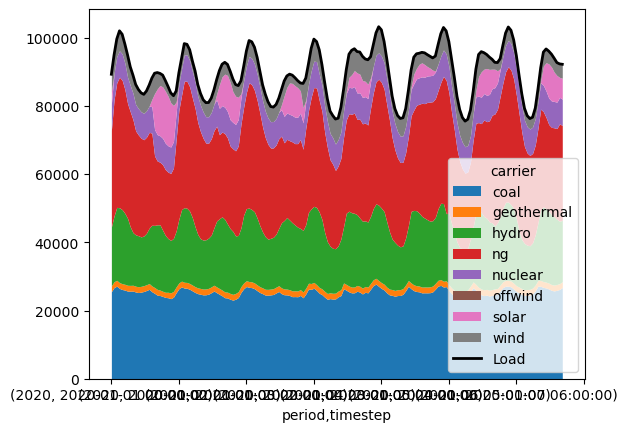

In [18]:
generation_ts = n.generators_t.p.loc[sim_snapshot]
ax = generation_ts.groupby(n.generators.carrier,axis=1).sum().plot(kind='area',stacked=True,linewidth=0,legend=True)
load_ts = n.loads_t.p.loc[sim_snapshot].sum(axis=1)
load_ts.plot( color='black',linewidth=2, label='Load',ax=ax,legend=True)
operation_costs = n.generators.marginal_cost * generation_ts
print("Total Operational Cost:  " , operation_costs.sum(axis=1).sum())

In [ ]:
n.export_to_netcdf('/Users/kamrantehranchi/Documents/GradSchool/Courses/Q5/Decision Making under Uncertainty/DMuU_TransmissionExpansion/pypsa_60_multiyear.nc')

## Adding Lines/Generators to Multi-Investment Period Model

In [46]:
n.remove("Line", "New_HVAC")
n.remove("Link", "New_HVDC")
n.remove("Generator", "Humboldt_OSW")

In [47]:
ows_cf = pd.read_csv('/Users/kamrantehranchi/Documents/GradSchool/Courses/Q5/Decision Making under Uncertainty/DMuU_TransmissionExpansion/OSW_CF_Humboldt.csv')


array([0.6946081 , 0.6946081 , 0.6946081 , ..., 0.79822267, 0.79822267,
       0.79822267])

In [48]:
n.line_types.loc["Rail"] = pd.Series(
    [60, 0.0683, 0.335, 15, 1.01],
    index=["f_nom", "r_per_length", "x_per_length", "c_per_length", "i_nom"],
    )

n.add("Line", "New_HVAC", bus0="CISO-PGAE0 13", bus1="CISO-PGAE0 16",
            r=0.815803, x=6.873208, b=0.000398 ,s_nom=536.51,length=400, 
            type="Rail",v_nom=230,
            x_pu= 0.000725,
            r_pu= 0.000085,
            g_pu= 0.0,
            b_pu= 7.557957,
            x_pu_eff= 0.000725,
            r_pu_eff= 0.000085,
            s_nom_opt= 2100.295202,
            )
# NB: for a lossless bi-directional HVDC or transport link, set p_min_pu = -1 and efficiency = 1. NB: It is assumed that the links neither produce nor consume reactive power.
n.add("Link", "New_HVDC", bus0="CISO-PGAE0 13", bus1="CISO-PGAE0 8",type="HVDC_VSC", carrier = "DC",
            efficiency=1,
            p_nom=100,
            p_min_pu=-1,
            )
n.add("Generator", "Humboldt_OSW", bus= "CISO-PGAE0 13", carrier="offwind",
            p_nom=4000,
            marginal_cost=0,
            p_max_pu=np.tile(ows_cf.cf_humboldt.values,6),
            )

In [26]:
simulation_hours = 168
sim_snapshot = n.snapshots[n.snapshots.get_level_values(0) == 2020][:simulation_hours]
n.lopf(sim_snapshot, solver_name="gurobi")

INFO:pypsa.linopf:Prepare linear problem
/Users/kamrantehranchi/opt/miniconda3/envs/pypsa-usa/lib/python3.10/site-packages/pypsa/linopt.py:473: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/Users/kamrantehranchi/opt/miniconda3/envs/pypsa-usa/lib/python3.10/site-packages/pypsa/linopt.py:473: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

INFO:pypsa.linopf:Total preparation time: 0.89s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/pypsa-problem-nofe_8cs.lp
Reading time = 0.23 seconds
obj: 137592 rows, 54485 columns, 269248 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 137592 rows, 54485 columns and 269248 nonzeros
Model fingerprint: 0x1d5eb190
Coefficient statistics:
  Matrix range     [2e-06, 1e+03]
  Objective range  [1e+00, 2e+05]
  Bounds range     [1e+00, 3e+09]
  RHS range        [1e+00, 6e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 115303 rows and 15958 columns
Presolve time: 0.18s
Presolved: 22289 rows, 38527 columns, 144646 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.17s

Barrier statistics:
 Dense cols 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.33e+08


('ok', 'optimal')

Total Operational Cost:   233245090.3580391


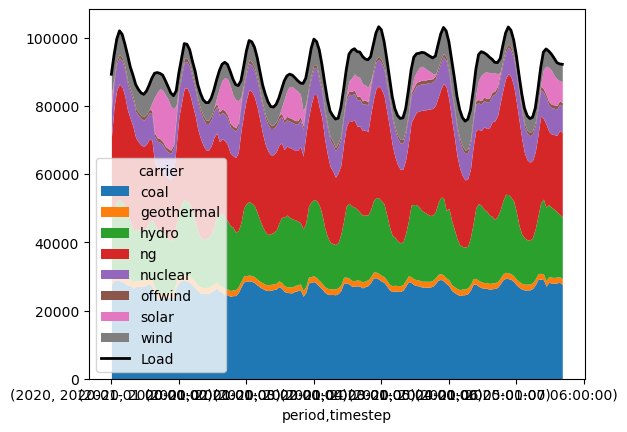

In [27]:
generation_ts = n.generators_t.p.loc[sim_snapshot]
ax = generation_ts.groupby(n.generators.carrier,axis=1).sum().plot(kind='area',stacked=True,linewidth=0,legend=True)
load_ts = n.loads_t.p.loc[sim_snapshot].sum(axis=1)
load_ts.plot( color='black',linewidth=2, label='Load',ax=ax,legend=True)
operation_costs = n.generators.marginal_cost * generation_ts
print("Total Operational Cost:  " , operation_costs.sum(axis=1).sum())

# Single Investment Period Network Simulation

## Running Simulation

In [7]:
simulation_hours = 2000
network.optimize(network.snapshots[0:simulation_hours], solver_name="gurobi")

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 5/5 [00:00<00:00,  9.87it/s]


Read LP format model from file /var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-qwvon68x.lp
Reading time = 2.43 seconds
obj: 1328054 rows, 544055 columns, 2498485 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1328054 rows, 544055 columns and 2498485 nonzeros
Model fingerprint: 0x3cb2a96b
Coefficient statistics:
  Matrix range     [1e-06, 2e+03]
  Objective range  [1e+00, 1e+05]
  Bounds range     [3e+09, 3e+09]
  RHS range        [9e-01, 3e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1125028 rows and 154975 columns
Presolve time: 2.36s
Presolved: 203026 rows, 389080 columns, 1247715 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.10s

Barrier statistics:


INFO:linopy.model: Optimization successful. Objective value: 2.14e+09


('ok', 'optimal')

In [5]:
load_ts = network.loads_t.p.iloc[0:simulation_hours].sum(axis=1)
load_ts

snapshot
2016-01-01 00:00:00     88760.839704
2016-01-01 01:00:00     94398.920636
2016-01-01 02:00:00     99026.967012
2016-01-01 03:00:00    101434.483510
2016-01-01 04:00:00    100431.005259
                           ...      
2016-01-09 03:00:00     99603.440265
2016-01-09 04:00:00     98659.093245
2016-01-09 05:00:00     96342.834806
2016-01-09 06:00:00     92919.973282
2016-01-09 07:00:00     88686.749252
Length: 200, dtype: float64

In [7]:
network.generators[network.generators.carrier == 'offwind'] #### why is there offshore wind?

,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,bus,p_nom_extendable,control,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,


<AxesSubplot: xlabel='snapshot'>

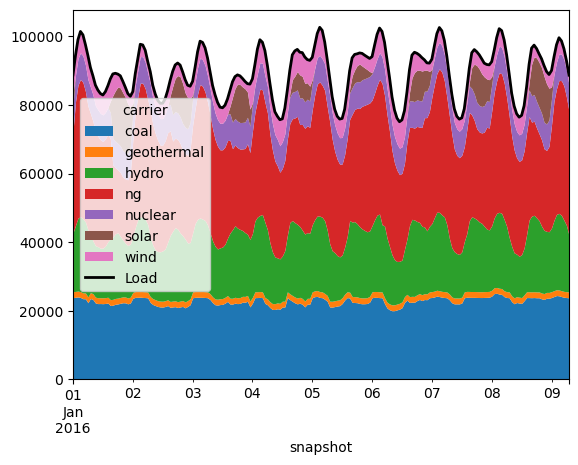

In [6]:
generation_ts = network.generators_t.p.iloc[0:simulation_hours]
ax = generation_ts.groupby(network.generators.carrier,axis=1).sum().plot(kind='area',stacked=True,linewidth=0,legend=True)
load_ts.plot( color='black',linewidth=2, label='Load',ax=ax,legend=True)

In [134]:
generation_ts.groupby(network.generators.carrier,axis=1).sum()

carrier,coal,geothermal,hydro,ng,nuclear,offwind,solar,wind
snapshot,,,,,,,,
2016-01-01 00:00:00,18194.393753,429.57,10168.407604,12769.529749,6532.6,5.740301,1865.838875,2065.798121
2016-01-01 01:00:00,18798.532728,429.57,11390.009228,16502.149855,6532.6,6.216704,0.000000,2461.861551
2016-01-01 02:00:00,18341.211655,429.57,12638.907305,19358.490856,6532.6,6.737958,0.000000,2470.715908
2016-01-01 03:00:00,17872.789080,429.57,12950.751851,20653.692968,6532.6,6.949289,0.000000,2672.649175
2016-01-01 04:00:00,18001.903915,429.57,12801.696573,20055.076764,6532.6,7.008960,0.000000,2620.159839
...,...,...,...,...,...,...,...,...
2016-01-07 19:00:00,18434.926487,429.57,12113.592316,12556.944754,6532.6,5.120867,4930.237038,1136.585458
2016-01-07 20:00:00,18383.572928,429.57,11867.428799,12716.168192,6532.6,5.392181,4698.272828,1227.332443
2016-01-07 21:00:00,18175.129829,429.57,11322.064893,12322.609978,6532.6,6.714265,4104.991308,1187.099549


In [136]:
operation_costs = network.generators.marginal_cost * generation_ts
operation_costs.sum(axis=1).sum()

227267443.92402208

## Adding Lines to System

In [137]:
network.iplot(mapbox=True, mapbox_token='pk.eyJ1Ijoia3RlaHJhbmNoaSIsImEiOiJjbDJzNW5kdHMwaGJzM2pudDBsazZ5am80In0.hQfjJnhiiO1-YcJEEpN-1A',size= (900,500));

In [49]:
network.lines

,bus0,bus1,r,x,b,s_nom,s_max_pu,length,num_parallel,type,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
Line,,,,,,,,,,,,,,,,,,,,,
1,AVA0 0,BPAT0 0,0.815803,6.873208,0.000398,9665.725271,1.0,418.235262,24.022854,,...,inf,0,0.000130,0.000015,0.0,21.034424,0.000130,0.000015,9665.725271,230.0
2,AVA0 0,DOPD0 0,0.979313,10.528460,0.000070,6696.342400,1.0,230.247931,16.642854,,...,inf,0,0.000199,0.000019,0.0,3.680059,0.000199,0.000019,6696.342400,230.0
3,AVA0 0,IPCO0 0,6.940746,211.460261,0.000026,4451.199253,1.0,614.940313,11.062854,,...,inf,0,0.003997,0.000131,0.0,1.366133,0.003997,0.000131,4451.199253,230.0
4,Arizona0 0,CISO-SCE0 0,2.218679,46.061683,0.000156,14359.486266,1.0,690.203291,35.688563,,...,inf,0,0.000871,0.000042,0.0,8.234615,0.000871,0.000042,14359.486266,230.0
5,Arizona0 0,IID0 0,2.931627,46.804543,0.000078,5457.087760,1.0,449.236637,13.562854,,...,inf,0,0.000885,0.000055,0.0,4.106688,0.000885,0.000055,5457.087760,230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,PNM0 0,US0 0,126.981961,665.507574,0.000065,100.588851,1.0,1672.802087,0.250000,,...,inf,0,0.012580,0.002400,0.0,3.414519,0.012580,0.002400,100.588851,230.0
166,PNM0 0,WACM0 0,3.371304,22.303651,0.000392,3175.534814,1.0,737.569625,7.975898,,...,inf,0,0.000422,0.000064,0.0,20.759549,0.000422,0.000064,3175.534814,230.0
167,PSCO0 0,WACM0 0,0.147587,1.097048,0.000524,23894.393595,1.0,185.532779,56.527183,,...,inf,0,0.000021,0.000003,0.0,27.710754,0.000021,0.000003,23894.393595,230.0


In [274]:
network.line_types.loc["Rail"] = pd.Series(
    [60, 0.0683, 0.335, 15, 1.01],
    index=["f_nom", "r_per_length", "x_per_length", "c_per_length", "i_nom"],
    )

# network.remove("Line", "New_HVAC")
# network.remove("Link", "New_HVDC")
# network.remove("Generator", "Humboldt_OSW")

In [268]:
network.add("Line", "New_HVAC", bus0="CISO-PGAE0 13", bus1="CISO-PGAE0 16",
            r=0.815803, x=6.873208, b=0.000398 ,s_nom=536.51,length=400, 
            type="Rail",v_nom=230,
            x_pu= 0.000725,
            r_pu= 0.000085,
            g_pu= 0.0,
            b_pu= 7.557957,
            x_pu_eff= 0.000725,
            r_pu_eff= 0.000085,
            s_nom_opt= 2100.295202,
            )

In [269]:
# NB: for a lossless bi-directional HVDC or transport link, set p_min_pu = -1 and efficiency = 1. NB: It is assumed that the links neither produce nor consume reactive power.
network.add("Link", "New_HVDC", bus0="CISO-PGAE0 13", bus1="CISO-PGAE0 8",type="HVDC_VSC", carrier = "DC",
            efficiency=1,
            p_nom=100,
            p_min_pu=-1,
            )

In [279]:
network.add("Generator", "Humboldt_OSW2", bus= "CISO-PGAE0 13", carrier="wind",
            p_nom=1000,
            marginal_cost=0,
            p_max_pu=1,
            )

In [277]:
network.generators

,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,bus,carrier,control,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
AVA0 0 hydro,35.0,2386.29,177345.216619,0.90,2386.29,0.000000,False,AVA0 0,hydro,Slack,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AVA0 0 ng,6.0,555.70,0.000000,0.41,0.00,27.588816,False,AVA0 0,ng,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AVA0 0 solar,2.0,57.90,35602.071244,1.00,57.90,0.000000,True,AVA0 0,solar,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AVA0 0 wind,1.0,105.30,96085.888020,1.00,105.30,0.000000,True,AVA0 0,wind,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
Arizona0 0 coal,13.0,6125.70,0.000000,0.33,0.00,26.010908,False,Arizona0 0,coal,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WACM0 0 hydro,30.0,906.30,177345.216619,0.90,906.30,0.000000,False,WACM0 0,hydro,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
WACM0 0 ng,19.0,358.09,0.000000,0.41,0.00,28.456748,False,WACM0 0,ng,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
WACM0 0 wind,21.0,1636.80,96085.888020,1.00,1636.80,0.000000,True,WACM0 0,wind,,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


## Re-running simulation

In [280]:
simulation_hours = 168
network.lopf(network.snapshots[0:simulation_hours], solver_name="gurobi")

INFO:pypsa.linopf:Prepare linear problem
/Users/kamrantehranchi/opt/miniconda3/envs/pypsa-usa/lib/python3.10/site-packages/pypsa/linopt.py:473: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/Users/kamrantehranchi/opt/miniconda3/envs/pypsa-usa/lib/python3.10/site-packages/pypsa/linopt.py:473: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

INFO:pypsa.linopf:Total preparation time: 0.91s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/pypsa-problem-wyyqlex7.lp
Reading time = 0.24 seconds
obj: 137592 rows, 54485 columns, 283696 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 137592 rows, 54485 columns and 283696 nonzeros
Model fingerprint: 0x91a835fd
Coefficient statistics:
  Matrix range     [2e-06, 1e+03]
  Objective range  [1e+00, 2e+05]
  Bounds range     [1e+00, 3e+09]
  RHS range        [1e+00, 6e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 114413 rows and 15069 columns
Presolve time: 0.19s
Presolved: 23179 rows, 39416 columns, 161229 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.25s

Barrier statistics:
 Dense cols 

INFO:pypsa.linopf:Optimization successful. Objective value: 2.20e+08


('ok', 'optimal')

In [281]:
operation_costs = network.generators.marginal_cost * generation_ts
operation_costs.sum(axis=1).sum()

219726225.53680354

## Examining Original BE Network

In [173]:
BE_network='/Users/kamrantehranchi/Library/CloudStorage/OneDrive-Stanford/Kamran_OSW/PyPSA_Models/pypsa-breakthroughenergy-usa/workflow/resources/western/elec.nc'
network_original = pypsa.Network(BE_network)

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, line_types, links, loads, transformers


In [176]:
network_original.buses

,Pd,v_nom,zone_id,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,,,
2010001,9.64,138.0,201,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
2010002,15.98,138.0,201,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
2010003,14.39,138.0,201,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
2010004,0.00,138.0,201,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
2010005,10.45,138.0,201,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090019,0.00,138.0,202,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
2090020,0.00,138.0,201,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
2090021,0.00,138.0,201,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,


## Other Exerimentation

In [18]:
network.buses_t.marginal_price

Bus,AVA0 0,Arizona0 0,Arizona0 1,Arizona0 2,Arizona0 3,BANC0 0,BPAT0 0,BPAT0 1,BPAT0 2,BPAT0 3,...,PNM0 0,PSCO0 0,PSCO0 1,PSCO0 2,PSEI0 0,TEPC0 0,TID0 0,US0 0,WACM0 0,WALC0 0
snapshot,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,27.111969,25.579690,24.120964,25.001718,26.591735,27.179381,26.952159,26.849407,27.293535,26.944032,...,25.013276,24.604291,24.603013,24.622363,27.080846,25.522038,27.252191,27.043101,24.599112,26.589459
2016-01-01 01:00:00,27.202508,25.675096,24.120964,25.069025,26.748962,27.189264,27.017497,27.006866,27.342663,27.036662,...,25.089295,24.704920,24.703719,24.721905,27.209681,25.613603,27.159676,27.084663,24.700053,26.735680
2016-01-01 02:00:00,27.202508,25.675096,24.120964,25.069025,26.748962,27.189264,27.017497,27.006866,27.342663,27.036662,...,25.089295,24.704920,24.703719,24.721905,27.209681,25.613603,27.159676,27.084663,24.700053,26.735680
2016-01-01 03:00:00,27.221538,25.709548,24.120964,25.091231,26.803516,27.332140,27.112982,27.016441,27.352678,27.099542,...,25.113172,24.714854,24.713610,24.732456,27.230373,25.647374,27.354392,27.196019,24.709811,26.792683
2016-01-01 04:00:00,27.221538,25.709548,24.120964,25.091231,26.803516,27.332140,27.112982,27.016441,27.352678,27.099542,...,25.113172,24.714854,24.713610,24.732456,27.230373,25.647374,27.354392,27.196019,24.709811,26.792683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-12-31 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-12-31 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
network.loads_t.p_set

Load,AVA0 0,Arizona0 0,Arizona0 1,Arizona0 2,Arizona0 3,BANC0 0,BPAT0 0,BPAT0 1,BPAT0 2,BPAT0 3,...,PNM0 0,PSCO0 0,PSCO0 1,PSCO0 2,PSEI0 0,TEPC0 0,TID0 0,US0 0,WACM0 0,WALC0 0
snapshot,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1798.275255,5611.506180,537.394352,336.128296,367.987464,2092.340502,2400.519295,386.808949,647.100273,1055.033225,...,1667.539675,4301.165220,79.137248,1546.134210,622.144017,1296.950351,208.831540,3288.609021,3191.755189,16.201784
2016-01-01 01:00:00,1940.834916,6243.099373,597.879827,373.960624,409.405645,2175.417081,2559.037237,413.946062,694.927474,1135.157078,...,1857.866376,4675.855894,86.031191,1680.823774,670.211573,1442.926313,213.434635,3470.667161,3437.728159,16.564049
2016-01-01 02:00:00,2045.244922,6617.712080,633.755177,396.399863,433.971738,2339.934349,2744.435735,438.424270,700.094623,1208.149196,...,1916.373722,4649.934521,85.554263,1671.505852,712.589079,1529.508073,223.313964,3669.487661,3423.861673,17.291151
2016-01-01 03:00:00,2015.488293,6545.610271,626.850239,392.080977,429.243495,2504.410687,2721.286195,431.380663,684.302265,1197.866828,...,1886.487669,4523.700952,83.231688,1626.128837,706.517185,1512.843658,249.320799,3817.111009,3349.894800,19.425135
2016-01-01 04:00:00,1973.190477,6433.084812,616.074069,385.340720,421.864379,2490.177631,2635.046070,422.089142,670.508562,1163.061062,...,1863.628416,4406.018631,81.066448,1583.825727,686.235190,1486.836392,251.491226,3768.475576,3304.245393,19.649029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1938.659580,5414.524712,518.530125,324.329138,355.069950,2129.064608,2559.383093,406.339675,652.325934,1150.382581,...,1615.327918,3686.732205,67.832279,1325.264781,680.371029,1251.423326,209.713895,3456.510903,2871.333322,16.264079
2016-12-31 20:00:00,1912.284577,5329.959886,510.431646,319.263719,349.524416,2133.304757,2530.483782,400.131489,637.320308,1138.264733,...,1566.091630,3634.400122,66.869420,1306.453036,673.270956,1231.878416,210.950837,3444.625705,2825.351029,16.362834
2016-12-31 21:00:00,1869.266758,5244.904463,502.286186,314.168913,343.946711,2096.067619,2471.436799,390.279927,623.171102,1113.747704,...,1556.158675,3591.278266,66.076020,1290.952079,658.925857,1212.220118,210.313279,3397.545661,2779.569818,16.303478


In [20]:
s=network.generators_t.p.sum().groupby(
    [network.generators.bus, network.generators.carrier]
).sum()
s

bus         carrier
AVA0 0      hydro      1.606211e+05
            ng         0.000000e+00
            solar      1.530844e+03
            wind       4.208671e+03
Arizona0 0  hydro      1.435887e+04
                           ...     
WACM0 0     coal       1.130957e+06
            hydro      3.612217e+04
            ng         0.000000e+00
            wind       1.051242e+05
WALC0 0     hydro      2.207453e+03
Length: 178, dtype: float64

In [93]:
# network.export_to_netcdf('Solved_Network_WECC.nc')

INFO:pypsa.io:Exported network Solved_Network_WECC_50.nc has carriers, links, loads, generators, lines, buses


<xarray.Dataset>
Dimensions:                       (snapshots: 8784, investment_periods: 0,
                                   carriers_i: 9, links_i: 2, links_t_p0_i: 2,
                                   links_t_p1_i: 2, links_t_mu_lower_i: 2,
                                   links_t_mu_upper_i: 2, loads_i: 50,
                                   loads_t_p_set_i: 50, loads_t_p_i: 50,
                                   generators_i: 160,
                                   ...
                                   generators_t_p_i: 144, lines_i: 128,
                                   lines_t_p0_i: 128, lines_t_p1_i: 128,
                                   lines_t_mu_lower_i: 15,
                                   lines_t_mu_upper_i: 15, buses_i: 50,
                                   buses_t_p_i: 50, buses_t_v_ang_i: 50,
                                   buses_t_marginal_price_i: 50)
Coordinates: (12/24)
  * snapshots                     (snapshots) int64 0 1 2 3 ... 8781 8782 8783
  * investment_periods            (investment_periods) float64 
  * carriers_i                    (carriers_i) object 'solar' ... 'oil'
  * links_i                       (links_i) object '9' '10'
  * links_t_p0_i                  (links_t_p0_i) object '9' '10'
  * links_t_p1_i                  (links_t_p1_i) object '9' '10'
    ...                            ...
  * lines_t_mu_lower_i            (lines_t_mu_lower_i) object '10' ... '128'
  * lines_t_mu_upper_i            (lines_t_mu_upper_i) object '10' ... '118'
  * buses_i                       (buses_i) object 'AVA0 0' ... 'WALC0 0'
  * buses_t_p_i                   (buses_t_p_i) object 'AVA0 0' ... 'WALC0 0'
  * buses_t_v_ang_i               (buses_t_v_ang_i) object 'AVA0 0' ... 'WALC...
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 'AVA0 0' ...
Data variables: (12/63)
    snapshots_snapshot            (snapshots) datetime64[ns] 2016-01-01 ... 2...
    snapshots_objective           (snapshots) float64 1.0 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 1.0 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 1.0 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) float64 
    investment_periods_years      (investment_periods) float64 
    ...                            ...
    buses_country                 (buses_i) object 'AVA' 'Arizona' ... 'WALC'
    buses_control                 (buses_i) object 'Slack' 'PQ' ... 'PQ' 'PQ'
    buses_generator               (buses_i) object 'AVA0 0 hydro' '' ... '' ''
    buses_t_p                     (snapshots, buses_t_p_i) float64 -900.9 ......
    buses_t_v_ang                 (snapshots, buses_t_v_ang_i) float64 -0.118...
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 ...
Attributes:
    network__cCounter:           6227857
    network__multi_invest:       0
    network__xCounter:           2547420
    network_max_memusage:        3125465088
    network_name:                
    network_objective:           8783072020.072104
    network_objective_constant:  2591285865.223094
    network_pypsa_version:       0.21.1
    network_srid:                4326
    meta:                        {"version": "0.5.0", "tutorial": false, "log...